In [33]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np

In [34]:
# train_data is an instance of the MNIST class and is not a tensor
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [35]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [36]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [37]:
# train_data.data is the actual data tensor with the images
# train_data.data.shape also gives the same result
train_data.data.size()

torch.Size([60000, 28, 28])

In [38]:
train_data.targets.size()

torch.Size([60000])

Below we use the DataLoader to load the data

In [39]:
from torch.utils.data import DataLoader
loaders = {
    "train": DataLoader(train_data,
                        batch_size=99, 
                        shuffle=True, 
                        num_workers=1),
    "test": DataLoader(test_data, 
                       batch_size=99, 
                       shuffle=True, 
                       num_workers=1),
}

In [48]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=10,
                               kernel_size=5,
                               stride=1)
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(10, 20, 5, 1)
        self.conv2_drop = nn.Dropout2d()
        # Fully Connected Layer 1
        self.fc1 = nn.Linear(in_features=20*4*4, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x, dim=-1)

Use GPU for training if available

In [49]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loaders["train"].dataset),
                100. * batch_idx / len(loaders["train"]), loss.item()))
            
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders["test"].dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loaders["test"].dataset),
        100. * correct / len(loaders["test"].dataset)))

In [50]:
for epoch in range(1, 15):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301358
Train Epoch: 1 [990/60000 (2%)]	Loss: 2.299943
Train Epoch: 1 [1980/60000 (3%)]	Loss: 2.292847
Train Epoch: 1 [2970/60000 (5%)]	Loss: 2.265851
Train Epoch: 1 [3960/60000 (7%)]	Loss: 2.112869
Train Epoch: 1 [4950/60000 (8%)]	Loss: 2.014577
Train Epoch: 1 [5940/60000 (10%)]	Loss: 1.967999
Train Epoch: 1 [6930/60000 (12%)]	Loss: 1.991625
Train Epoch: 1 [7920/60000 (13%)]	Loss: 1.862885
Train Epoch: 1 [8910/60000 (15%)]	Loss: 1.953652
Train Epoch: 1 [9900/60000 (16%)]	Loss: 1.937257
Train Epoch: 1 [10890/60000 (18%)]	Loss: 1.855459
Train Epoch: 1 [11880/60000 (20%)]	Loss: 1.921089
Train Epoch: 1 [12870/60000 (21%)]	Loss: 1.790385
Train Epoch: 1 [13860/60000 (23%)]	Loss: 1.823493
Train Epoch: 1 [14850/60000 (25%)]	Loss: 1.867862
Train Epoch: 1 [15840/60000 (26%)]	Loss: 1.865422
Train Epoch: 1 [16830/60000 (28%)]	Loss: 1.825123
Train Epoch: 1 [17820/60000 (30%)]	Loss: 1.821961
Train Epoch: 1 [18810/60000 (31%)]	Loss: 1.678570
Train Epoch: 1 [19800

Prediction:  9


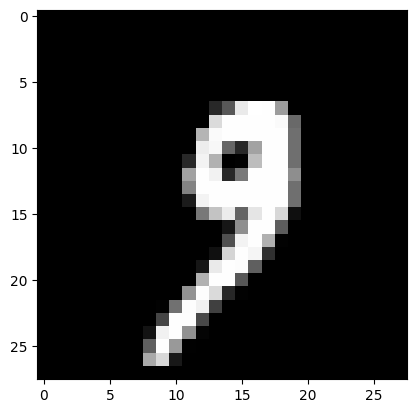

In [63]:
import matplotlib.pyplot as plt
model.eval()
data, target = test_data[1000]
data = data.unsqueeze(0).to(device)
output = model(data)

predicition = output.argmax(dim=1, keepdim=True).item()
print('Prediction: ', predicition)
image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()

Prediction:  7


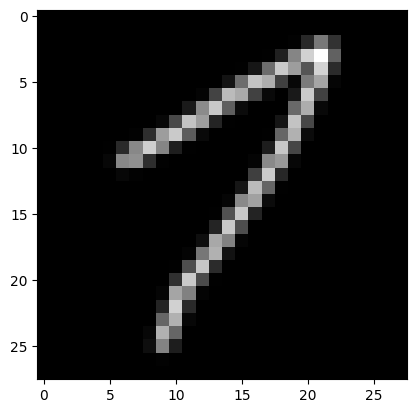

In [52]:
# trying out uploading your own image
import torchvision.transforms as transforms
from PIL import Image
image = Image.open('seven.jpg')

image = image.convert('L') # for grayscale

transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to the size your model expects
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with the same mean and std used during training
])

image = transform(image)
image = image.unsqueeze(0).to(device)

output = model(image)

predicition = output.argmax(dim=1, keepdim=True).item()
print('Prediction: ', predicition)
img = image.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(img, cmap='gray')
plt.show()


In [31]:
# save the model for onnx
dummy_input = torch.randn(1, 1, 28, 28).to(device)
onnx_model_path = 'model.onnx'
torch.onnx.export(
    model.to(device),                # Model to be exported
    dummy_input,          # Dummy input tensor
    onnx_model_path,      # Path to save the ONNX model
    input_names=['input'],  # Input tensor name
    output_names=['output'],  # Output tensor name
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},  # Dynamic axes for variable batch size
    opset_version=11      # ONNX opset version
)

print(f'Model exported to {onnx_model_path}')

C:\Users\sunit\AppData\Local\Temp\ipykernel_9640\3749221115.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Model exported to model.onnx


In [53]:
# save model for streamlit
scripted_model = torch.jit.script(model)
scripted_model.save("mnist_model_scripted.pth")